# EfficientNetB0V2 with SMOTE for Imbalanced data with final dataset

# Import Libraries

In [85]:
from clearml import Task
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import random
import shutil
from glob import glob
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import albumentations as A


In [2]:
task = Task.init(project_name='Architecture Style Classification', task_name='Efficientnet with focal loss and CSAM, try normalisation')

MissingConfigError: It seems ClearML is not configured on this machine!
To get started with ClearML, setup your own 'clearml-server' or create a free account at https://app.clear.ml
Setup instructions can be found here: https://clear.ml/docs

# Data Extraction

In [8]:
# dataset_path = "D:/University/FinalDatasetSplited/train"
dataset_path = "/Users/anna/University/Thesis_datseets/FinalDatasetSplitted/train/"
def get_image_paths_and_labels(directory_path):
    data = []
    for root, dirs, files in os.walk(directory_path):
        for label in dirs:
            label_path = os.path.join(root, label)
            for image_path in glob(os.path.join(label_path, "*")):  
                if os.path.isfile(image_path):
                    label_hierarchy = os.path.relpath(label_path, directory_path).split(os.path.sep)
                    label_string = ", ".join(label_hierarchy)
                    data.append((image_path, label_string))

    return data

In [9]:
images_with_labels = get_image_paths_and_labels(dataset_path)
data = pd.DataFrame(images_with_labels, columns=['image_name', 'label'])
data

,image_name,label
0,/Users/anna/University/Thesis_datseets/FinalDa...,"Modernism, International style"
1,/Users/anna/University/Thesis_datseets/FinalDa...,"Modernism, International style"
2,/Users/anna/University/Thesis_datseets/FinalDa...,"Modernism, International style"
3,/Users/anna/University/Thesis_datseets/FinalDa...,"Modernism, International style"
4,/Users/anna/University/Thesis_datseets/FinalDa...,"Modernism, International style"
...,...,...
16291,/Users/anna/University/Thesis_datseets/FinalDa...,"Classical, Ancient Egyptian architecture"
16292,/Users/anna/University/Thesis_datseets/FinalDa...,"Classical, Ancient Egyptian architecture"
16293,/Users/anna/University/Thesis_datseets/FinalDa...,"Classical, Ancient Egyptian architecture"
16294,/Users/anna/University/Thesis_datseets/FinalDa...,"Classical, Ancient Egyptian architecture"


# Data Exploration

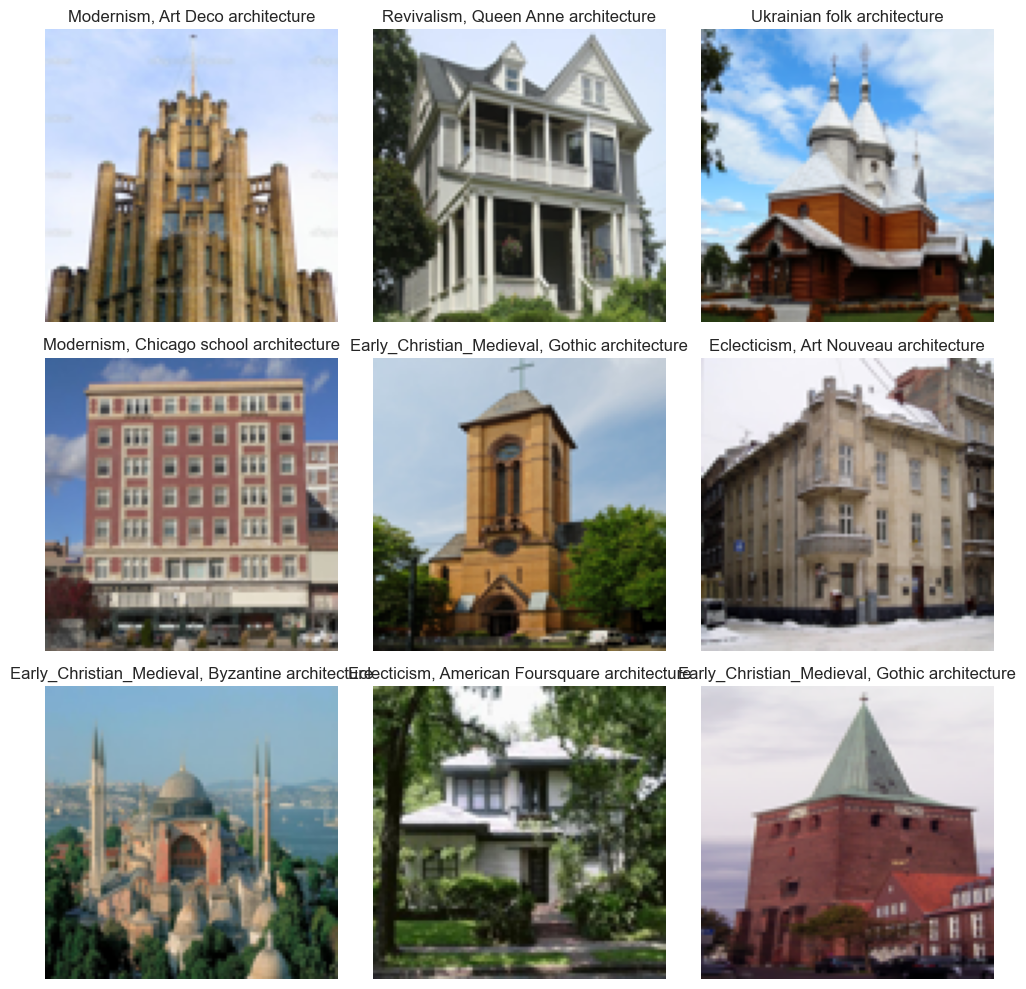

In [10]:
classes = [subfolder for subfolder in os.listdir(dataset_path) if
           os.path.isdir(os.path.join(dataset_path, subfolder))]
plt.figure(figsize=(10, 10))
data_to_show = data.sample(frac=1)[:9]

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    img = Image.open(data_to_show.iloc[i, 0])  # Opening the image
    img_resized = img.resize((100, 100))
    plt.imshow(img_resized)
    plt.title(data_to_show.iloc[i, 1])  # Convert one-hot encoded labels to class names
    plt.axis("off")
plt.tight_layout()
plt.show()

# Data Split

In [11]:
train_dataset, validation_dataset = train_test_split(data,
                                               stratify=data['label'],
                                               test_size=0.2,
                                               random_state=42)
print(f"Train : Validation {train_dataset.shape} : {validation_dataset.shape}")

Train : Validation (13036, 2) : (3260, 2)


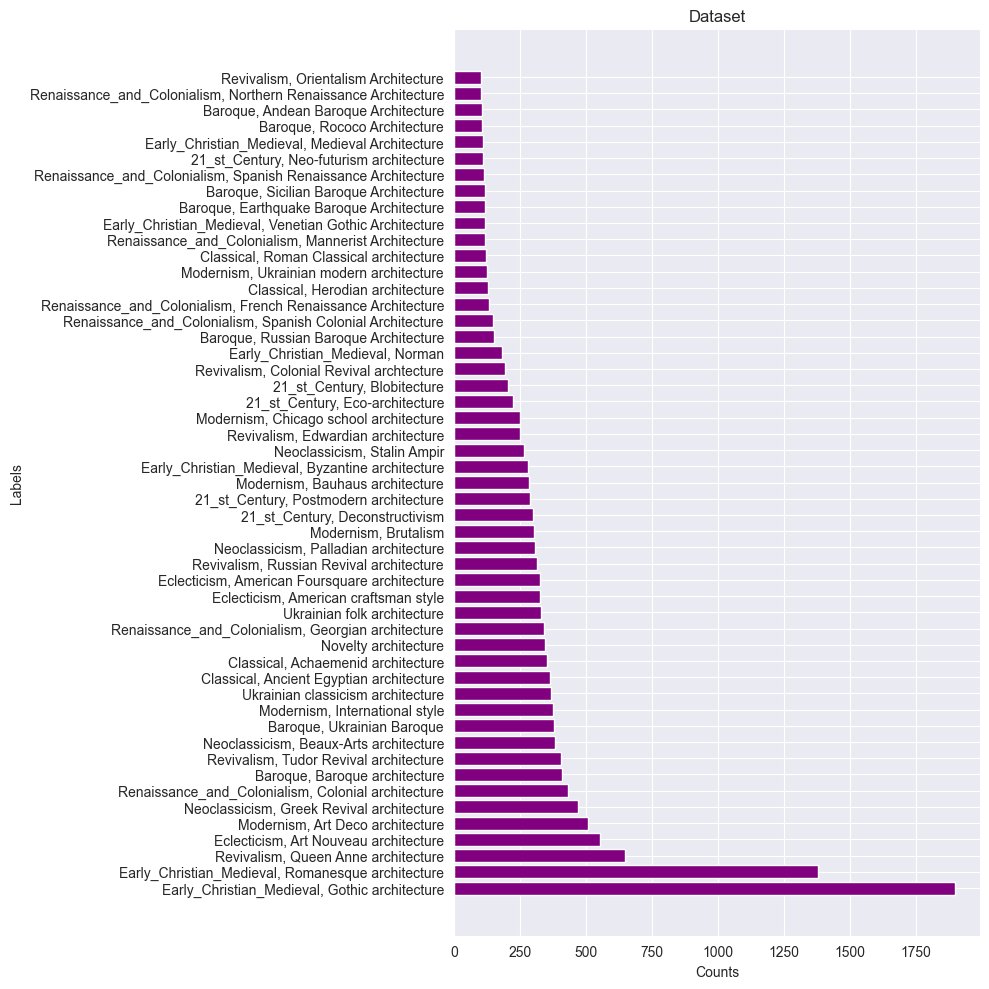

In [12]:
general_dataset_labels = data['label'].value_counts()
unique_labels = general_dataset_labels.index.tolist()
unique_labels.sort(key=lambda label: general_dataset_labels[label], reverse=True)

plt.figure(figsize=(10, 10))
plt.barh(range(len(unique_labels)), [general_dataset_labels.get(label, 0) for label in unique_labels], color='purple')
plt.title('Dataset')

plt.xlabel('Counts')
plt.ylabel('Labels')
plt.yticks(range(len(unique_labels)), unique_labels)
plt.tight_layout()
plt.show()


# Image Data Generators

In [87]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
IMG_CHANNELS = 3

abs_file_names = []


augmentation = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.ColorJitter(p=0.5),
    A.RandomGamma(p=0.5),
    A.GaussNoise(p=0.5)
])

def albumentations_augmentation(image):
    augmented_image = augmentation(image=image)['image']
    return augmented_image


# Define a combined preprocessing function
def combined_preprocessing(image):
    # Apply preprocessing function from EfficientNet
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    # Apply additional augmentation using imgaug
    image = albumentations_augmentation(image)
    return image
train_datagen = ImageDataGenerator(
    preprocessing_function=combined_preprocessing,
    zoom_range=0.3,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.4, 1.5],
)

test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,)

train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    num_workers=4,
)

validation_generator = test_datagen.flow_from_dataframe(
    validation_dataset,
    directory=None,
    target_size=IMG_SIZE,
    x_col='image_name',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    num_workers=4,
)

Found 13032 validated image filenames belonging to 51 classes.
Found 3259 validated image filenames belonging to 51 classes.


/Users/anna/DataspellProjects/TestGPU/venv/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(
/Users/anna/DataspellProjects/TestGPU/venv/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


# Creating Model

In [88]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)

In [89]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [90]:
def channel_attention(input_tensor, ratio=8):
    # Channel attention mechanism
    channels = input_tensor.shape[-1]
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    shared_layer_one = tf.keras.layers.Dense(channels // ratio,
                                    activation='relu',
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    shared_layer_two = tf.keras.layers.Dense(channels,
                                    kernel_initializer='he_normal',
                                    use_bias=True,
                                    bias_initializer='zeros')
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    combined = tf.keras.layers.Add()([avg_pool, max_pool])
    output_tensor = tf.keras.layers.Activation('sigmoid')(combined)
    return tf.keras.layers.Multiply()([input_tensor, output_tensor])

In [91]:
def spatial_attention(input_tensor):
    # Spatial attention mechanism
    avg_pool =  tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_tensor)
    max_pool = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_tensor)
    concat = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
    conv = tf.keras.layers.Conv2D(filters=1,
                         kernel_size=(7, 7),
                         padding='same',
                         activation='sigmoid',
                         kernel_initializer='he_normal',
                         use_bias=False)(concat)
    output_tensor = tf.keras.layers.Multiply()([input_tensor, conv])
    return output_tensor

In [92]:
def cbam_block(input_tensor):
    # CBAM block combining channel and spatial attention
    channel = channel_attention(input_tensor)
    spatial = spatial_attention(input_tensor)
    output_tensor = tf.keras.layers.Concatenate()([channel, spatial])
    return output_tensor

In [93]:
def arc_model(image_shape=IMG_SIZE):
    input_shape = image_shape + (3,)

    inputs = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.EfficientNetV2B0(input_tensor=inputs,
                                                        include_top=False,
                                                        weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output  # Use the output of the base model directly

    x = cbam_block(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Increasing the number of neurons
    x = tf.keras.layers.Dropout(0.5)(x)  # Adding dropout for regularization
    outputs = tf.keras.layers.Dense(51, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    return model

In [94]:
arch_model = arc_model(IMG_SIZE)
# Print a summary for each layer
# print(arch_model.summary())

In [95]:
arch_model.compile( tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=["accuracy"])
# Image.MAX_IMAGE_PIXELS = None

In [39]:
def unfreeze_model(model):
    # Unfreeze all layers
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    # Use a learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalFocalCrossentropy(),
        metrics=["accuracy"]
    )

    return model


In [22]:
unfreeze_model(arch_model)

<Functional name=functional_1, built=True>

In [96]:
res = arch_model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data = validation_generator,
    callbacks=[learning_rate_reduction, early_stopping],
)

Epoch 1/50


/Users/anna/DataspellProjects/TestGPU/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-07 09:39:57.377223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-07 09:40:09.481928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 19443s 96s/step - accuracy: 0.0883 - loss: 0.9025 - val_accuracy: 0.1341 - val_loss: 0.8521 - learning_rate: 1.0000e-04
Epoch 2/50


2024-05-07 15:03:51.471784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-07 15:04:03.999452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


204/204 ━━━━━━━━━━━━━━━━━━━━ 1059s 5s/step - accuracy: 0.1071 - loss: 0.8735 - val_accuracy: 0.1522 - val_loss: 0.7804 - learning_rate: 1.0000e-04
Epoch 3/50


2024-05-07 15:21:26.283995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:32: Filling up shuffle buffer (this may take a while): 4 of 8
2024-05-07 15:21:38.112527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


 24/204 ━━━━━━━━━━━━━━━━━━━━ 13:37 5s/step - accuracy: 0.1063 - loss: 0.8612

KeyboardInterrupt: 

In [24]:
    # validation_steps=20)
acc = [0.] + res.history['accuracy']
val_acc = [0.] + res.history['val_accuracy']

loss = res.history['loss']
val_loss = res.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'res' is not defined

In [22]:
test_generator = test_datagen.flow_from_directory(
    directory='D:/University/FinalDatasetSplited/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 1808 images belonging to 51 classes.


In [23]:
loss, accuracy = arch_model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=0)
print('Test Loss:', loss, 'Test Accuracy:', accuracy)

C:\Users\User\DataspellProjects\Thesis_final_models\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Test Loss: 0.2261311411857605 Test Accuracy: 0.6238937973976135


In [24]:
loss, accuracy = arch_model.evaluate(train_generator, batch_size=BATCH_SIZE, verbose=0)
print('Train Loss:', loss, 'Train Accuracy:', accuracy)

Train Loss: 0.07878564298152924 Train Accuracy: 0.8065531253814697


In [25]:
loss, accuracy = arch_model.evaluate(validation_generator, batch_size=BATCH_SIZE, verbose=0)
print('Validation Loss:', loss, 'Validation Accuracy:', accuracy)

Validation Loss: 0.2205253541469574 Validation Accuracy: 0.6158331036567688


In [26]:
prediction = arch_model.predict(test_generator, batch_size=BATCH_SIZE, verbose=0)
pr = np.argmax(prediction, axis=1)
print(classification_report(test_generator.labels, pr, target_names=unique_labels))

                                                                precision    recall  f1-score   support

                 Early_Christian_Medieval, Gothic architecture       0.68      0.74      0.71        23
             Early_Christian_Medieval, Romanesque architecture       0.71      0.79      0.75        34
                           Revivalism, Queen Anne architecture       0.89      0.64      0.74        25
                         Eclecticism, Art Nouveau architecture       0.60      0.27      0.38        11
                              Modernism, Art Deco architecture       0.76      0.59      0.67        32
                     Neoclassicism, Greek Revival architecture       0.50      0.58      0.54        12
            Renaissance_and_Colonialism, Colonial architecture       0.45      0.67      0.54        46
                                 Baroque, Baroque architecture       0.60      0.23      0.33        13
                        Revivalism, Tudor Revival architecture 

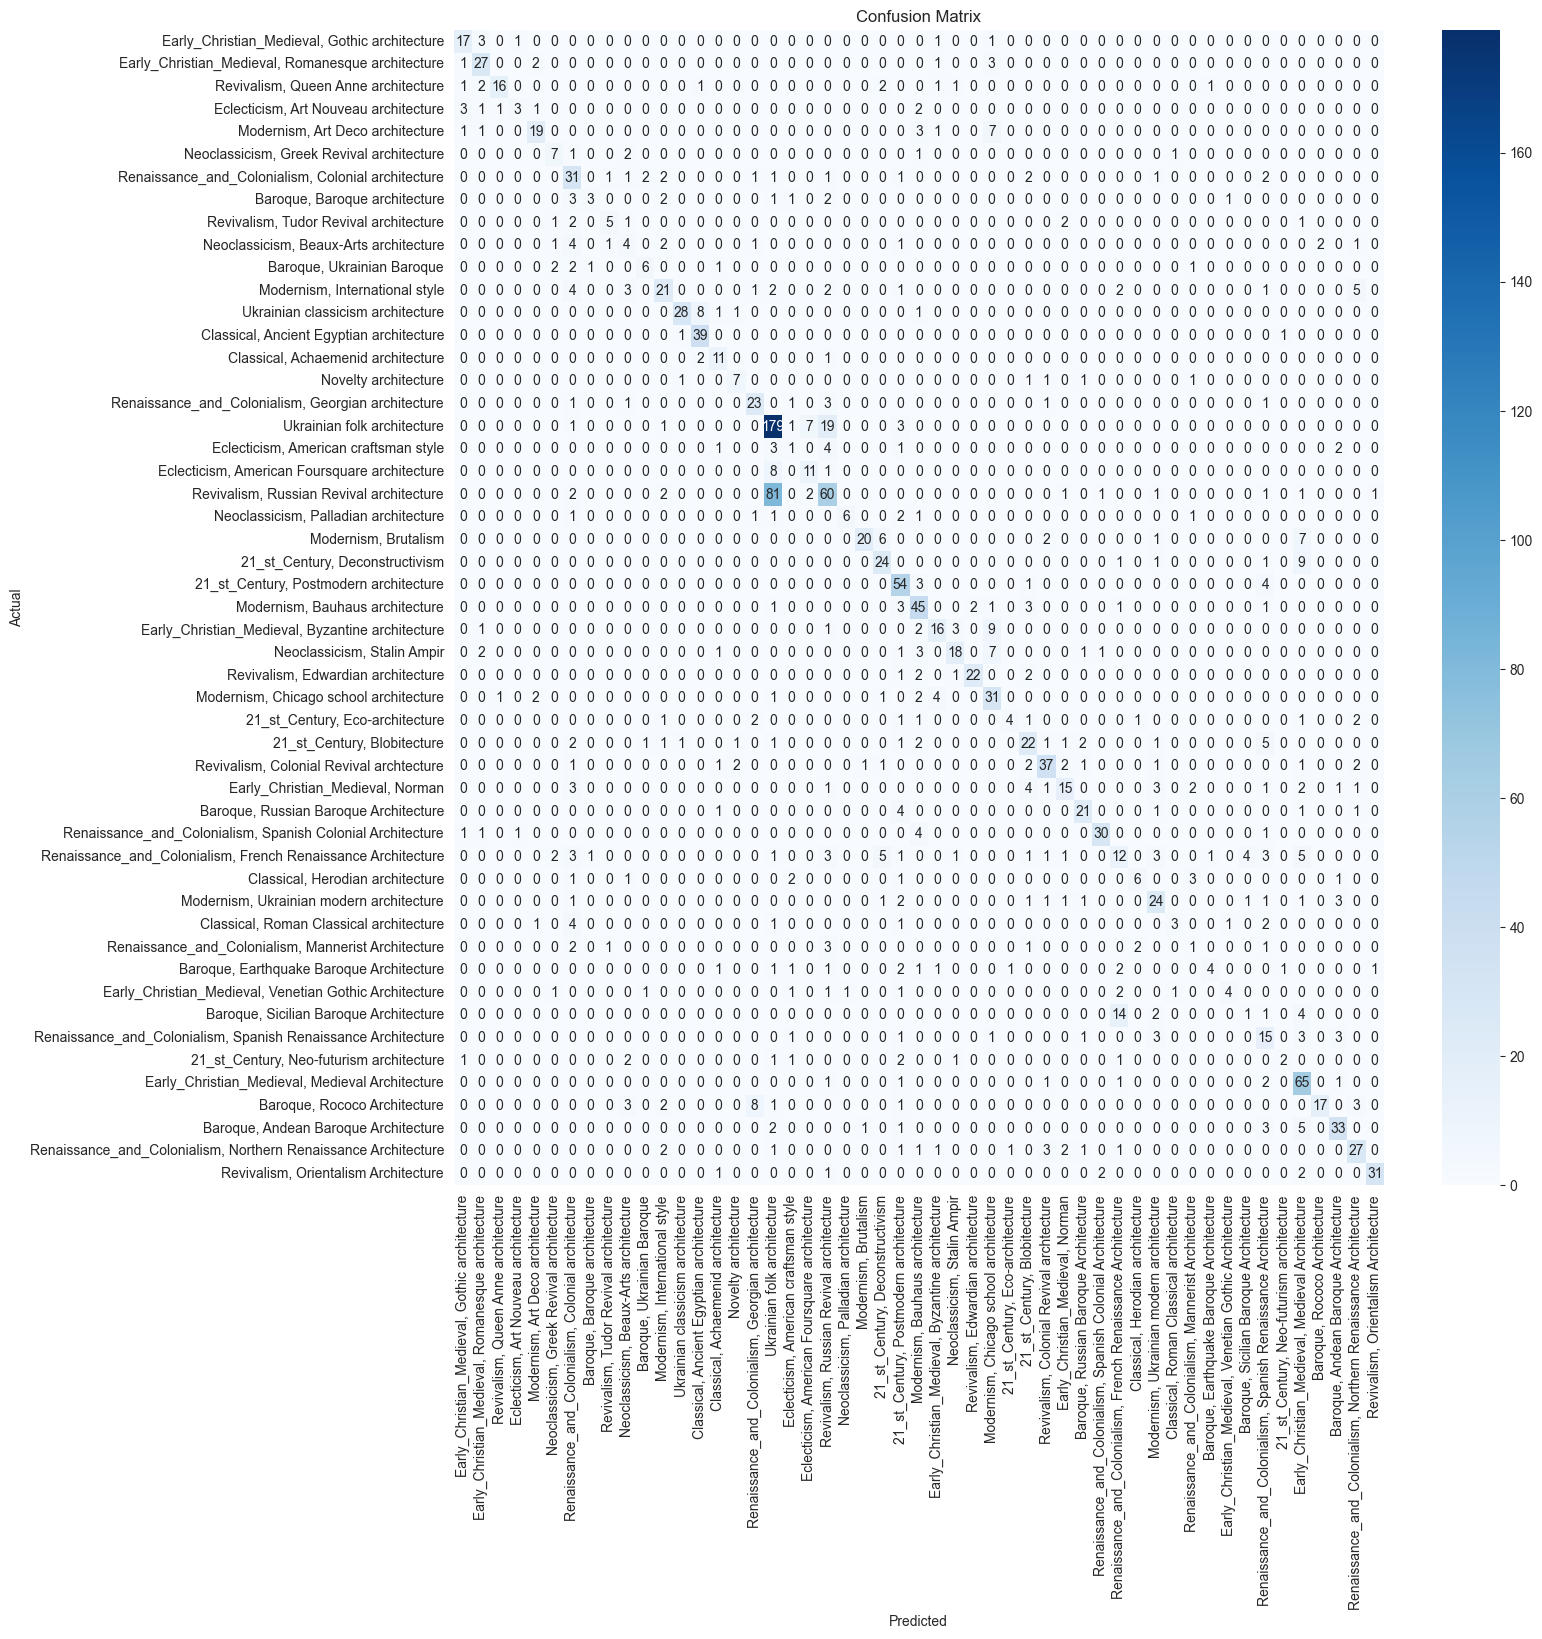

In [27]:
conf_matrix = confusion_matrix(test_generator.labels, pr)
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
for epoch, history in enumerate(res.history['loss']):
    task.get_logger().report_scalar("training", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['accuracy']):
    task.get_logger().report_scalar("training", "accuracy", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_loss']):
    task.get_logger().report_scalar("validation", "loss", history, iteration=epoch)
for epoch, history in enumerate(res.history['val_accuracy']):
    task.get_logger().report_scalar("validation", "accuracy", history, iteration=epoch)


In [29]:
arch_model.save("focal_cbam_adaptive.h5")

In [30]:
task.upload_artifact(artifact_object="focal_cbam_adaptive.h5", name="imbalanced")

True